In [8]:
from matplotlib import pyplot as plt
from itertools import product
import seaborn as sns
import numpy as np
import pandas as pd
import os.path as op
import argparse
import re
import glob
# EEG utilities
import mne
from pycrostates.cluster import ModKMeans
from pycrostates.io import read_cluster, ChData
# BIDS utilities
from util.io.bids import DataSink
from bids import BIDSLayout

In [3]:
# constants
BIDS_ROOT = '../data/bids'
DERIV_ROOT = op.join(BIDS_ROOT, 'derivatives')
TASK = 'pitch'
MIN_TRIAL_CUTOFF = 100 # subjects must have this many trials in *every* condition to be included

layout = BIDSLayout(BIDS_ROOT, derivatives = True)

/project/hcn1/.conda/envs/mne/lib/python3.11/site-packages/bids/layout/validation.py:124: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [4]:
# get filenames for subject-level microstates
fpaths = glob.glob('../data/bids/derivatives/microstates/sub-*/sub-*_task-pitch_desc-microstates_ModKMeans.fif.gz')
# and sort by subject number
sub_num = lambda f: int(re.findall('sub-(\w+)_', f)[0])
fpaths.sort(key = sub_num)

In [5]:
# load cluster centers for individually computed miscrostates
clusts_indiv = [read_cluster(f) for f in fpaths]
centers_indiv = [clust.cluster_centers_ for clust in clusts_indiv]
group_cluster_centers = np.vstack(centers_indiv).T
group_cluster_centers = ChData(group_cluster_centers, clusts_indiv[0].info)
# drop channel marked as Iz in first subject, since this electrode
# has an inconsistent location between subjects (sometimes placed at FCz)
group_cluster_centers = group_cluster_centers.pick(None, exclude = ['Iz'])

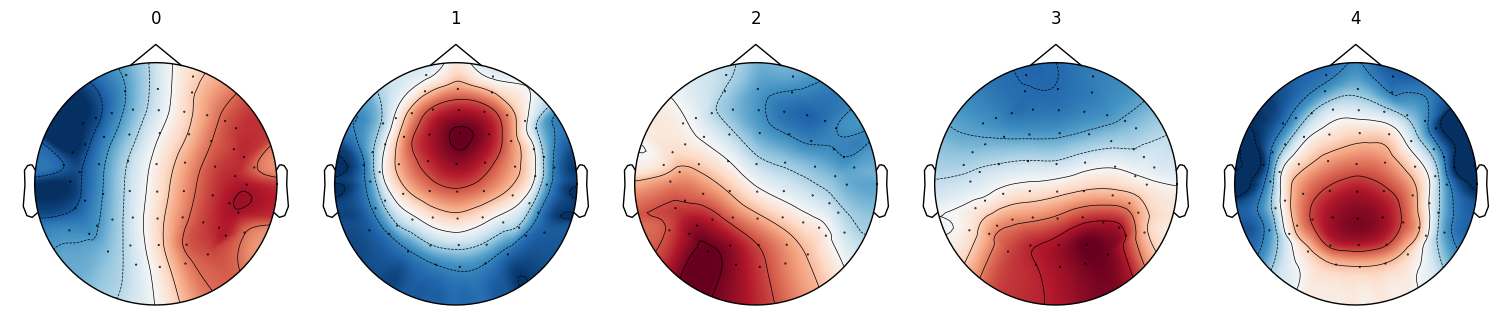

<Figure size 640x480 with 0 Axes>

In [6]:
# group level clustering
ModK = ModKMeans(n_clusters = 5, random_state = 0)
ModK.fit(group_cluster_centers, n_jobs = -1)
ModK.plot()
plt.show()
plt.savefig('microstate-topos.jpeg', dpi = 300, bbox_inches = 'tight')

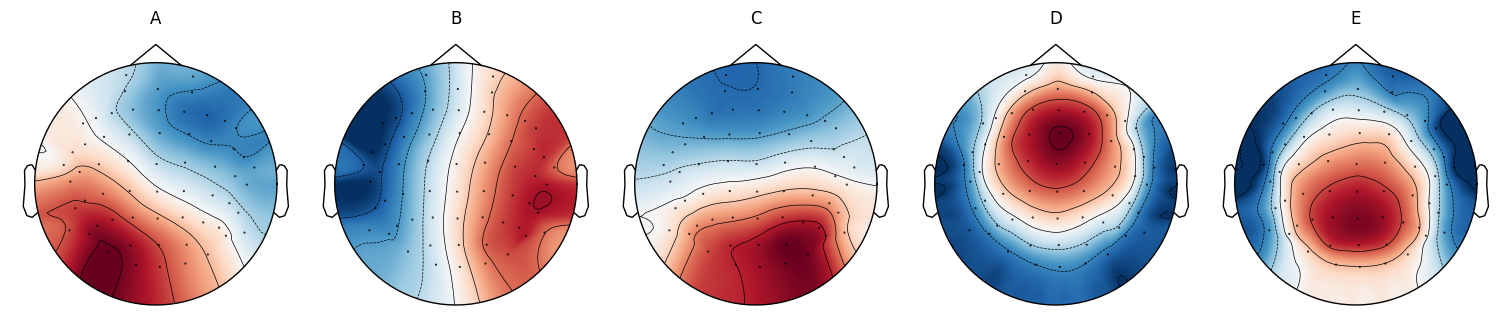

<Figure size 640x480 with 0 Axes>

In [7]:
# re-order based on visual similarity to canonical microstates topographies 
ModK.reorder_clusters(order = [2, 0, 3, 1, 4])
ModK.rename_clusters(new_names = ['A', 'B', 'C', 'D', 'E'])
# ModK.invert_polarity([False, False, False, False, False]) # only affects visualization
ModK.plot()
plt.savefig('microstate-topos.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [8]:
# save solution
clust_fpath = op.join(DERIV_ROOT, 'microstates', 'clusters_group.fif.gz')
ModK.save(clust_fpath)

In [9]:
subs = layout.get_subjects()
subs.sort(key = int)
sub = subs[11]

In [10]:
def read_epochs(sub, desc):
    '''
    reads and concatenates epochs across runs
    '''
    layout = BIDSLayout(BIDS_ROOT, derivatives = True)
    run = lambda f: int(re.findall('run-(\w+)_', f)[0])
    fnames = layout.get(
        return_type = 'filename',
        subject = sub, desc = desc
        )
    fnames.sort(key = run)
    epochs_all = [mne.read_epochs(f) for f in fnames]
    epochs = mne.concatenate_epochs(epochs_all)
    epochs = epochs.pick('eeg')
    return epochs

In [11]:
def compute_spectrum_dB(epo):
    '''
    Computes power spectrum of frequency following response
    '''
    # assert(epo.tmin == -epo.tmax)
    poststim = epo.average().compute_psd(tmin = 0., tmax = 0.2)
    baseline = epo.average().compute_psd(tmin = -0.2, tmax = 0.)
    power = 10 * np.log10(poststim.get_data() / baseline.get_data())
    power = np.squeeze(power)
    return poststim.freqs, power

In [46]:
# subs = layout.get_subjects(scope = 'microstates')
# subs.sort(key = int)

# params = list()
# all_spectrums = list()
# tag_mapping = {'1': 130, '2': 200, '3': 280}

# for sub in subs:
#     print(f'sub: {sub}')

#     # get last microstate observed before each stimulus is delivered
#     epochs = read_epochs(sub, 'forMicrostate')
#     segmentation = ModK.predict(epochs, reject_edges = False)
#     labels = [segmentation.cluster_names[idx] for idx in segmentation.labels[:, -1]]
    
#     # Save params
#     d = segmentation.compute_parameters()
#     d["sub"] = sub
#     params.append(d)

#     # read FFR epochs and assign microstate labels
#     epochs = read_epochs(sub, 'forFFR')
#     mapping = {epochs.event_id[key]: key for key in epochs.event_id}
#     event_names = np.array([mapping[ev] for ev in epochs.events[:, -1]])
#     df = pd.DataFrame({'stimulus': event_names, 'microstate': labels})
#     epochs.metadata = df

#     # compute FFR spectrums for each microstate x stim
#     micros = segmentation.cluster_names
#     print(micros)
#     stims = np.unique(event_names)
#     for microstate, stim in product(micros, stims):
#         try:
#             epo = epochs["microstate == '%s'"%microstate][stim]
#         except:
#             print(f'Sub {sub} is missing event tags {stim}!')
#             continue
#         freqs, spectrum = compute_spectrum_dB(epo)
#         df = pd.DataFrame(
#             {'subject': sub,
#              'target': tag_mapping[stim[0]],
#              'stim': tag_mapping[stim[1]],
#              'microstate': microstate,
#              'frequency': freqs,
#              'power': spectrum
#             }
#         )
#         df['trials'] = epo.events.shape[0]
#         all_spectrums.append(df)

# # compile into one big dataframe
# spectrums = pd.concat(all_spectrums)

# # # Save for later
# spectrums.to_csv('microstates-spectrums.csv', sep = '\t', index = True)

# Load saved spectrums
spectrums = pd.read_csv('microstates-spectrums.csv', sep = '\t', index_col = 0)
spectrums

,subject,target,stim,microstate,frequency,power,trials
0,3,130,130,A,0.000000,-3.571834,84
1,3,130,130,A,4.979253,-3.362666,84
2,3,130,130,A,9.958506,-3.585764,84
3,3,130,130,A,14.937759,-3.509687,84
4,3,130,130,A,19.917012,-3.581047,84
...,...,...,...,...,...,...,...
116,45,280,280,E,577.593361,0.715499,99
117,45,280,280,E,582.572614,0.026099,99
118,45,280,280,E,587.551867,0.987278,99
119,45,280,280,E,592.531120,-0.258015,99


In [49]:
# Exclude subjects with missing data
subs = np.unique(spectrums.subject)
exclude = list()
for sub in subs:
    if np.shape(spectrums[spectrums.subject == sub]) != (5445, 7):
        exclude.append(sub)

spectrums = spectrums[~spectrums.subject.isin(exclude)]
np.unique(spectrums.subject)

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 44, 45])

In [52]:
## we can do ANOVAa seperately for each stimulus 
## so long as we correct for multiple comparisons, anyway,
## but it feels kind of silly...

all_stims_power = []

for stim_freq in np.unique(spectrums.stim):
    
    print('\n%d Hz stimulus:'%stim_freq)

    # select Fourier frequency nearest to stimulus frequency 
    idx = np.abs(spectrums.frequency - stim_freq).argmin()
    hz = spectrums.frequency[idx].iloc[0]
    power_f0 = spectrums[spectrums.frequency == hz]
    power_f0 = power_f0[power_f0.stim == stim_freq]

    all_stims_power.append(power_f0)

    # perform a repeated measures anova 
    from statsmodels.stats.anova import AnovaRM
    aov = AnovaRM(
        data = power_f0, 
        depvar = 'power',
        subject = 'subject', 
        within = ['microstate', 'target']
    )
    res = aov.fit()
    print(res)


130 Hz stimulus:
                     Anova
                  F Value Num DF  Den DF  Pr > F
------------------------------------------------
microstate         2.5285 4.0000 160.0000 0.0427
target             3.7597 2.0000  80.0000 0.0275
microstate:target  0.6074 8.0000 320.0000 0.7716


200 Hz stimulus:
                     Anova
                  F Value Num DF  Den DF  Pr > F
------------------------------------------------
microstate         0.4052 4.0000 160.0000 0.8047
target             0.4573 2.0000  80.0000 0.6346
microstate:target  1.6673 8.0000 320.0000 0.1055


280 Hz stimulus:
                     Anova
                  F Value Num DF  Den DF  Pr > F
------------------------------------------------
microstate         0.2162 4.0000 160.0000 0.9292
target             0.1288 2.0000  80.0000 0.8793
microstate:target  0.5194 8.0000 320.0000 0.8417



In [9]:
## better to just add a fixed effect for stimulus frequency 
power_f0 = pd.concat(all_stims_power)
power_f0 = power_f0.reset_index(drop = True)
power_f0.to_csv('microstates-power_f0.csv', index = False)

aov = AnovaRM(
    data = power_f0, 
    depvar = 'power',
    subject = 'subject', 
    within = ['microstate', 'target', 'stim']
)
res = aov.fit()
print(res)

                        Anova
                       F Value  Num DF  Den DF  Pr > F
------------------------------------------------------
microstate              0.7515  4.0000 160.0000 0.5584
target                  2.6684  2.0000  80.0000 0.0755
stim                    8.4137  2.0000  80.0000 0.0005
microstate:target       1.1368  8.0000 320.0000 0.3380
microstate:stim         1.1225  8.0000 320.0000 0.3475
target:stim             0.8336  4.0000 160.0000 0.5057
microstate:target:stim  0.7894 16.0000 640.0000 0.6986



#### Multi-level model

In [10]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [63]:
## format data for multilevel model
sub = LabelEncoder().fit_transform(power_f0.subject)

le_stim = LabelEncoder() # we'll hold onto this encoder for later
stim = le_stim.fit_transform(power_f0.stim)

scaler = StandardScaler() # we can set priors on unit scale
power = scaler.fit_transform(power_f0.power.to_numpy()[:, np.newaxis])[:, 0]

le_ms = LabelEncoder() 
microstate = le_ms.fit_transform(power_f0.microstate)

le_target = LabelEncoder() 
target = le_target.fit_transform(power_f0.target)

In [64]:
## fit Bayesian multilevel model
with pm.Model() as model:
    # each microstate has some mean power at F0
    mu = pm.Normal('means', 0, 1, size = np.unique(microstate).size)
    # there may be tone-by-tone variation though, and we randomly sampled tones
    # from the "population" of possible tones, so that's a random effect
    z_stim = pm.Normal('z_stim', 0, 1, size = np.unique(stim).size)
    sigma_stim = pm.Exponential('sigma_stim', 1)
    stim_effect = z_stim*sigma_stim
    # and also a random effect for the subject
    z_sub = pm.Normal('z_sub', 0, 1, size = np.unique(sub).size)
    sigma_sub = pm.Exponential('sigma_sub', 1)
    sub_effect = z_sub*sigma_sub
    # random effect for target
    z_target = pm.Normal('z_target', 0, 1, size = np.unique(target).size)
    sigma_target = pm.Exponential('sigma_target', 1)
    target_effect = z_target*sigma_target
    # put it all together
    yhat = mu[microstate] + stim_effect[stim] + sub_effect[sub] + target_effect[target]
    sigma = pm.Exponential('sigma', 1) # noise prior
    pm.Normal('likelihood', yhat, sigma, observed = power)

    trace = pm.sample(
        chains = 4, 
        cores = 4, 
        draws = 2500, # per chain
        target_accept = .95, 
        random_seed = 0
    )

Output()

There were 38 divergences after tuning. Increase `target_accept` or reparameterize.


In [67]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],-0.05,0.22,-0.50,0.35,0.01,0.01,634.55,1125.56,1.02
means[1],-0.04,0.22,-0.49,0.38,0.01,0.01,636.00,1118.40,1.02
means[2],-0.00,0.22,-0.42,0.43,0.01,0.01,638.93,1129.02,1.02
means[3],0.05,0.22,-0.37,0.49,0.01,0.01,625.13,1148.66,1.02
means[4],-0.01,0.22,-0.42,0.44,0.01,0.01,641.47,1060.63,1.02
sigma,0.83,0.01,0.80,0.86,0.00,0.00,8866.23,7456.70,1.00
sigma_stim,0.36,0.24,0.07,0.81,0.01,0.00,1725.00,3512.07,1.00
sigma_sub,0.55,0.07,0.43,0.68,0.00,0.00,1169.61,2258.01,1.00
sigma_target,0.11,0.14,0.00,0.34,0.00,0.00,2452.76,3139.62,1.00
z_stim[0],-0.89,0.71,-2.21,0.42,0.02,0.01,1534.74,1544.93,1.00


In [68]:
## extract posterior sample for quantities of interest
trc = trace.posterior.stack(draws = ("chain", "draw")) # get samples
mu = scaler.inverse_transform(trc['means'].values) # convert back to dB
delta = np.stack([mu - mu[i, :] for i in range(mu.shape[0])], axis = 0) 
print('mu: (microstates, samples) = (%d, %d)'%mu.shape)
print('delta: (microstates, microstates, samples) = (%d, %d, %d)'%delta.shape)

mu: (microstates, samples) = (5, 10000)
delta: (microstates, microstates, samples) = (5, 5, 10000)


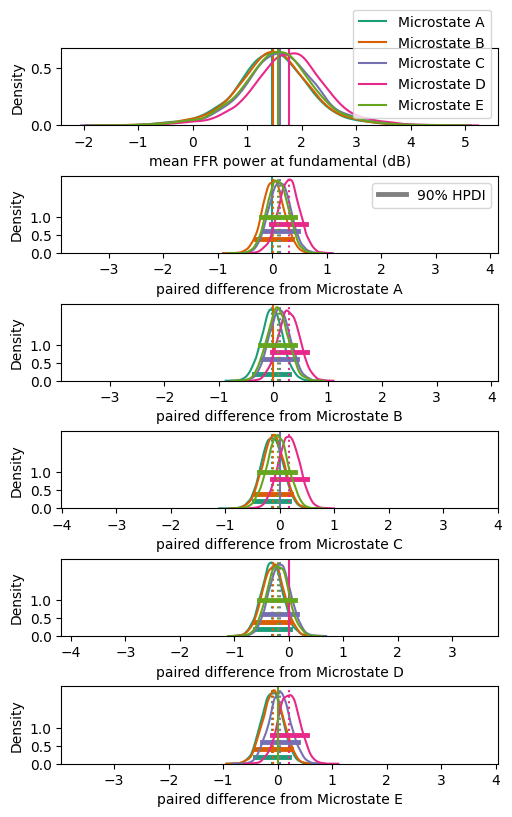

In [72]:
## plot posterior distribtuions for each microstate and their differences
fig, axs = plt.subplots(6, 1, figsize = (5, 8), constrained_layout=True)
colors = plt.colormaps['Dark2'].colors[:5]

# plot posterior means
for i in range(mu.shape[0]):
    ms = le_ms.inverse_transform([i])[0]
    sns.kdeplot(mu[i, :], color = colors[i], ax = axs[0])
    axs[0].axvline(mu[i, :].mean(), color = colors[i], label = 'Microstate %s'%ms)
axs[0].legend()
# axs[0].set_xlim(3, 9)
axs[0].set_xlabel('mean FFR power at fundamental (dB)')
xmin, xmax = axs[0].get_xlim()

# plot posteriors of differences in mean
for i in range(delta.shape[0]):
    ms = le_ms.inverse_transform([i])[0]
    ax = axs[i + 1]
    ax.set_xlim(xmin - mu[i, :].mean(), xmax - mu[i, :].mean())
    ax.set_xlabel('paired difference from Microstate %s'%ms)
    ax.set_yticks([0, .5, 1.])
    ms = le_ms.inverse_transform([i])[0]
    for j in range(delta.shape[1]):
        if i != j:
            # ax.axvline(delta[i, j].mean(), color = colors[j], linestyle = 'dotted')
            sns.kdeplot(delta[i, j], color = colors[j], ax = ax)
            hdi_prob = .9
            hdi = az.hdi(delta[i, j], hdi_prob = hdi_prob)
            ax.plot([hdi[0], hdi[1]], [.2*(j+1), .2*(j+1)], color = colors[j], linewidth = 3.5)
        else:
            ax.axvline(delta[i, j].mean(), color = colors[j])
    if i == 0:
        ax.plot([], [], color = 'grey', linewidth = 3.5, label = '%d%% HPDI'%(hdi_prob*100))
        ax.legend()
        break
    break

plt.savefig('posteriors.jpeg', dpi = 500, bbox_inches = 'tight')
plt.show()

In [19]:
import dabest

def plot(stim_freq):

    dat = []
    
    fig = plt.figure(figsize = (12, 5))
    gs = fig.add_gridspec(2, 4, wspace = .35)
        
    kwargs = dict(
        data = power_f0[power_f0.stim == stim_freq], 
        x = 'microstate',
        y = 'power',
        paired = 'baseline', 
        id_col = 'subject'
    )
    data = dabest.load(
        idx = ['A', 'B', 'C', 'D', 'E'],
        **kwargs
    )
    # dat.append(data)
    # axs = fig.add_subplot(gs[:, 0])
    # data.cohens_d.plot(ax = axs, contrast_ylim = (-.7, .7))
    
    # data = dabest.load(
    #     idx = ['B', 'C', 'D', 'E'],
    #     **kwargs
    # )
    # dat.append(data)
    # axs = fig.add_subplot(gs[:, 1])
    # data.cohens_d.plot(ax = axs, contrast_ylim = (-.7, .7))
    
    # data = dabest.load(
    #     idx = ['C', 'D', 'E'],
    #     **kwargs
    # )
    # dat.append(data)
    # axs = fig.add_subplot(gs[:, 2])
    # data.cohens_d.plot(ax = axs, contrast_ylim = (-.7, .7), float_contrast = False)
    
    # plt.savefig(f'../figs/{stim_freq}-paired-differences.jpeg', dpi = 300, bbox_inches = 'tight')
    # plt.show()
    return data

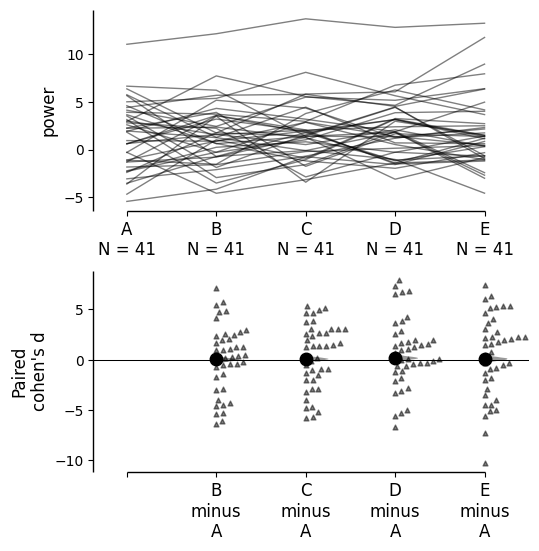

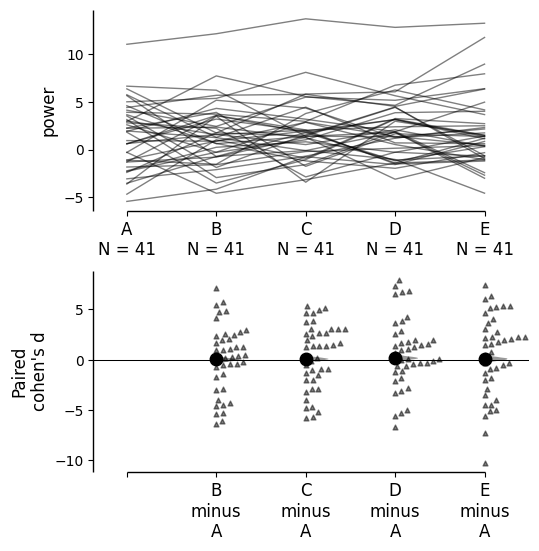

In [45]:
stim_freq = 130
kwargs = dict(
    data = power_f0[power_f0.stim == stim_freq], 
    x = 'microstate',
    y = 'power',
    paired = 'baseline', 
    id_col = 'subject'
)
data = dabest.load(
    idx = ['A', 'B', 'C', 'D', 'E'],
    **kwargs
)
# dat.append(data)
# axs = fig.add_subplot(gs[:, 0])
data.cohens_d.plot()
# data.cohens_d.plot(ax = axs, contrast_ylim = (-.7, .7))

ValueError: Index contains duplicate entries, cannot reshape

<Figure size 1200x500 with 0 Axes>

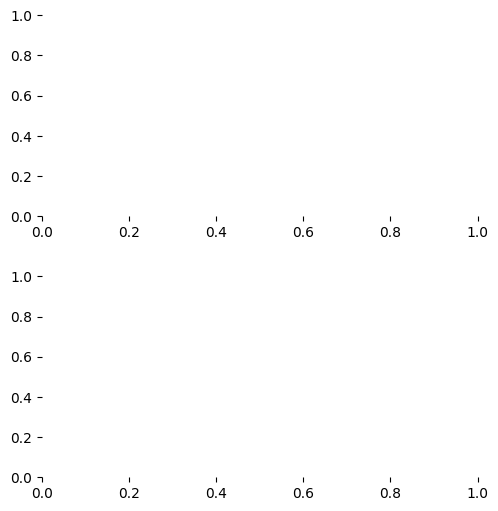

In [21]:
data = plot(130)
data
data.cohens_d.plot()

ValueError: Index contains duplicate entries, cannot reshape

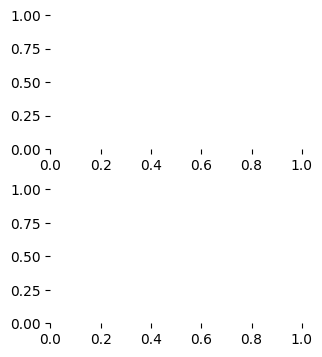

In [38]:
# data = dict()
# for i in [130, 200, 280]:
#     data[i] = plot(i)

In [49]:
power_f0[power_f0.subject == '3']

,subject,target,stim,microstate,frequency,power,trials
0,3,130,130,E,131.561462,-0.869510,364
1,3,200,130,E,131.561462,11.207483,368
2,3,280,130,E,131.561462,4.069259,312
3,3,130,130,B,131.561462,2.520809,97
4,3,200,130,B,131.561462,5.263240,137
5,3,280,130,B,131.561462,3.713733,99
6,3,130,130,C,131.561462,1.018914,101
7,3,200,130,C,131.561462,1.777885,128
8,3,280,130,C,131.561462,1.228259,112
9,3,130,130,E,131.561462,-0.869510,364


In [69]:
import dabest


def plot(stim):

    dat = []
    
    fig = plt.figure(figsize = (12, 4))
    gs = fig.add_gridspec(2, 3, wspace = .35)
        
    kwargs = dict(
        data = power_f0[power_f0.stimulus == stim], 
        x = 'microstate',
        y = 'power',
        paired = 'baseline', 
        id_col = 'subject'
    )
    data = dabest.load(
        idx = ['A', 'B', 'C', 'D'],
        **kwargs
    )
    dat.append(data)
    axs = fig.add_subplot(gs[:, 0])
    data.cohens_d.plot(ax = axs, contrast_ylim = (-.7, .7))
    
    data = dabest.load(
        idx = ['B', 'C', 'D'],
        **kwargs
    )
    dat.append(data)
    axs = fig.add_subplot(gs[:, 1])
    data.cohens_d.plot(ax = axs, contrast_ylim = (-.7, .7))
    
    data = dabest.load(
        idx = ['C', 'D'],
        **kwargs
    )
    dat.append(data)
    axs = fig.add_subplot(gs[:, 2])
    data.cohens_d.plot(ax = axs, contrast_ylim = (-.7, .7), float_contrast = False)
    
    plt.savefig('%dhz-paired-differences.jpeg'%stim_freq, dpi = 300, bbox_inches = 'tight')
    plt.show()
    return dat

In [72]:
power_f0

,subject,stimulus,microstate,frequency,power,trials
39,3,11,0,129.639889,1.350162,117
39,3,11,1,129.639889,0.482475,99
39,3,11,2,129.639889,1.197406,151
39,3,11,3,129.639889,0.381341,95
39,3,11,4,129.639889,4.373432,100
...,...,...,...,...,...,...
84,42,33,0,279.224377,5.090524,53
84,42,33,1,279.224377,5.727148,132
84,42,33,2,279.224377,4.659900,51
84,42,33,3,279.224377,3.850390,98


In [71]:
data = dict()
for stim in stim_to_stim_freq.keys():
    data[i] = plot(stim)

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/dabest/_classes.py:238: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if g not in data_in[x].unique():


IndexError: "A" is not a group in the column `microstate`. Please check `idx` and try again.

<Figure size 1200x400 with 0 Axes>

In [ ]:
from matplotlib.lines import Line2D

# average dB scale FFR spectrums across subjects
ffrs = spectrums.groupby(['stimulus', 'frequency']).mean()

# and plot 
fig, ax = plt.subplots()
for stim in [50, 100, 150, 200, 250]:
    p = ax.plot(ffrs.loc[stim].index, ffrs.loc[stim].power)
    c = p[-1].get_color()
    ax.axvline(stim, color = c, linestyle = '--')
legend_elements = [
    Line2D([0], [0], color = 'black', linestyle = '--', label = 'stimulus frequency'),
    Line2D([0], [0], color = 'black', linestyle = '-', label = 'frequency following response'),
    ]
ax.legend(handles = legend_elements, loc = 'upper left')
ax.set_xlabel('frequency')
ax.set_ylabel('power (dB)')
plt.savefig('FFRs.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()

In [ ]:
# bootstrap 95% confidence interval for Cohen's d effect sizes 
data[50][0].cohens_d.results[['control', 'test', 'bca_low', 'difference', 'bca_high', 'pvalue_permutation']]

In [ ]:
data[50][1].cohens_d.results[['control', 'test', 'bca_low', 'difference', 'bca_high', 'pvalue_permutation']]

In [ ]:
data[150][1].cohens_d.results[['control', 'test', 'bca_low', 'difference', 'bca_high', 'pvalue_permutation']]

In [ ]:
data[200][1].cohens_d.results[['control', 'test', 'bca_low', 'difference', 'bca_high', 'pvalue_permutation']]

### Global Explained Variance

In [ ]:
data = [
    [d['A_gev'], d['B_gev'], d['C_gev'], d['D_gev']]
    for d in params
]

plt.violinplot(np.array(data))
plt.title("Global Explained Variance (%)")
plt.xticks(
    ticks=range(1, len(ModK.cluster_names) + 1),
    labels=ModK.cluster_names,
)
plt.ylim([0, 0.40])
plt.savefig('microstate-GEV.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()

print(f'Means: {np.mean(data, axis = 0)}')
print(f'Sd: {np.std(data, axis = 0)}')

### Get means and sds following each microstates

In [ ]:
power_f0.groupby(['stimulus', 'microstate'])['power'].mean()

In [ ]:
power_f0.groupby(['stimulus', 'microstate'])['power'].std()